# SEN1221 Statistical Analysis of Choice Behaviour 

## `Session Lab 02:`
## `The Mixed Logit model`

**Delft University of Technology**<br>
**Q2 2023**<br>
**Instructor:** Sander van Cranenburgh<br>
**TA:**  Gabriel Nova <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Illustrate how models and theory discussed in the classroom work out in practice.
* Help you gather hands-on modelling and data analysis skills.


**Lab sessions are:**<br>
* Learning environments where you work with Python and get support from TA and fellow students.
* Not graded and do not have to be submitted.
* A good preparation for the graded partial exam.

### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers, you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively**. However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it to conduct proper analysis. We recommend being especially **reticent** with using AI tools for the more conceptual and reflection-oriented questions. <br>
Futhermore **be aware** that during the `partial exam`, you will not have access to these tools (since internet access will be restricted).

### `Workspace set-up`

**Option 1: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment, to install all dependencies on your Python version.

In [2]:
#!pip install -r requirements.txt

**Option 2: Google Colab**<br>
Uncomment the following cell if you are running this notebook on Colab

In [1]:
#!git clone https://github.com/SEN1221TUD/Q2_2023
#!mv "/content/Q2_2023/Lab sessions/lab_session_2/data" /content/data
#!mv "/content/Q2_2023/Lab sessions/lab_session_2/biogeme.toml" /content

#!pip install biogeme
#import os
#os.kill(os.getpid(), 9)

### `Application: Estimating the Value of Travel Time`

In this lab session, we will investigate the "Value of Travel Time" (VTT) distribution. The VTT of a traveller reflects the amount of money the traveller is **willing to pay** to reduce their travel time. The VTT is used to determine the benefits of new infrastructure projects. As travel time savings are the dominant and most salient benefits of new infrastructure, accurate inference of the distribution of the VTT is crucial for a rigorous underpinning of policy decisions. <br>

During this lab, we will apply Mixed Logit choice models. We aim to uncover how tastes for travel time and travel cost are distributed in the population. Most of the analyses in this lab session are carried out in the so-called willingness-to-pay space. Willingness-to-pay space facilitates the inference of the VTT distribution.<br>

For this study, we will use Stated Choice (SC) data (`Norway_VTT_2009.csv`) collected in 2009 to compute the Norwegian VTT. In this SC experiment, respondents faced nine choice tasks involving two alternatives and two attributes (travel cost and travel time). The data set consists of 5,832 participants, resulting in a total of 52,488 choice observations. The figure below shows one of the choice tasks (note that for the purposes of illustration we converted the currency unit (Kronor) into euros).

![SC](data/sc_experiment.png)

**`Learning objectives lab session 02`**

After completing the following exercises, you will be able to:
* Estimate Mixed Logit models that capture taste heterogeneity and panel effects
* Interpret the modelling outcomes of Mixed Logit models
* Specify utility models in Willingness-to-pay space
* Discuss the impact of the number of draws on the modelling outcomes



**`This lab consists of 5 parts and has 3 exercises`**

**Part 1**: Load and explore the data set

**Part 2**: Linear-additive RUM-MNL model

**Part 3**: Mixed Logit model for capturing taste heterogeneity 

**Part 4**: Willingness-to-Pay space 
- Exercise 1: "ML with log-normally distributed VTT"

**Part 5**: Panel Mixed Logit model

- Exercise 2: "Panel ML model with log-normally distributed VTT"

- Exercise 3: "Impact of the number of draws"



### `Import packages`

To begin, we will import all the libraries that we will use in this lab.

In [1]:
# Biogeme
import biogeme.logging as blog
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, bioDraws, log, MonteCarlo, exp, bioMultSum, exp

# General packages
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import toml
import time
from scipy.stats import norm, lognorm

# Pandas setting to show all columns when displaying a pandas dataframe
pd.set_option('display.max_columns', None)


## `1. Load and explore the data set` <br>

First, we load the data.

In [2]:
# 1. Load the data set
data_path = Path('data/Norway_VTT_2009.csv')
df = pd.read_table(data_path, sep=',')

# Show descriptive statistics
round(df.describe(),2)

,RespID,CostL,CostR,TimeL,TimeR,Chosen,Mode,Purpose,Gender,AgeClass,IncClass
count,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.00,52488.0
mean,32776.25,181.57,184.83,98.50,97.83,1.48,1.85,3.28,1.45,3.20,5.0
std,14995.46,281.07,286.95,134.33,133.42,0.50,1.80,1.64,0.50,0.99,2.3
min,32.00,4.00,4.00,6.00,6.00,1.00,1.00,1.00,1.00,1.00,1.0
25%,19195.25,25.00,25.00,18.00,17.00,1.00,1.00,2.00,1.00,2.00,4.0
50%,33039.50,69.00,70.00,40.00,40.00,1.00,1.00,4.00,1.00,3.00,5.0
75%,45333.00,236.00,238.00,121.00,122.00,2.00,2.00,5.00,2.00,4.00,6.0
max,60130.00,5282.00,5221.00,2011.00,1855.00,2.00,8.00,5.00,2.00,5.00,11.0


This data set contains the following variables:<br>

| Variable       | Description                                                  | Type    |
|---------------|-------------------------------------------------------------|---------|
| `RespID`        | Unique identifier for each survey response             | Integer |
| `CostL`         | Travel cost of left alternative [min]                  | Decimal |
| `CostR`         | Travel cost of right alternative [min]                 | Decimal |
| `TimeL`         | Travel time of left alternative [eur]                  | Decimal |
| `TimeR`         | Travel time of right alternative [eur]                 | Decimal |
| `Chosen`        | Indicates the alternative chosen       | Categorical |
| `Mode`          | Type of Transport mode               | Categorical    |
| `Gender`        | Gender of the respondent                                     | Categorical    |
| `AgeClass`      | Classification of the respondent's age                       | Categorical    |
| `IncClass`      | Classification of the respondent's income                    | Categorical    |
| `Purpose`       | Purpose of the trip                                     | Integer    |


Now, we take the following data preprocessing steps:

1. We keep only observations for the purpose 'long distance commute' and travel model 'car'.

2. We convert the unit of cost from Norwegian Krone to euros to ease interpretation.

In [3]:
# 1. Keep only entries purpose == 5 (Long distance trips) & Mode == 1 (Car)
df = df.loc[(df['Purpose'] == 5) & (df['Mode'] == 1)]

In [4]:
# 2. Convert the monetary unit to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

## `2. Linear-additive RUM-MNL model`<br>
We first estimate a linear-aditive RUM-MNL model. This model serves as our **benchmark** to compare against. But, before we can do this, we need to create the Biogeme database object and specify the optimiser and logger settings. 

`Biogeme database`<br>
To estimate a model in Biogeme, we must create the data set as a Biogeme database object and the attributes as Biogeme variable objects.

In [5]:
# Create Biogeme database object
biodata = db.Database('Norway2009VTT', df)

# Create Biogeme variable objects
CostL  = Variable('CostL')
CostR  = Variable('CostR')
TimeL  = Variable('TimeL')
TimeR  = Variable('TimeR')
Chosen = Variable('Chosen')	

`Biogeme optimiser and logging settings`<br>
The file `biogeme.toml` contains the settings for the optimiser. In this file, we set the number of draws for estimating Mixed Logit models to 50. We use a relatively low number to avoid long estimation times.<br>
Also, we invoke a so-called `logger` which enables us to see the progress during estimation.<br>

In [6]:
# Change the number of draws in the .toml file
with open('biogeme.toml', 'r') as file:
    tomldata = toml.load(file)

# Modify the number of draws
tomldata['MonteCarlo']['number_of_draws'] = 50

# Write the modified data back to the .toml file
with open('biogeme.toml', 'w') as file:
    toml.dump(tomldata, file)

# Create a logger to monitor the estimation progress
# if logger does not exist create it, else use it
try:
    logger
except NameError:    
    logger = blog.get_screen_logger(level=blog.INFO)

`Create a linear-additive RUM-MNL model`<br>
Now, we have the biogeme database object and set the environment, we can estimate our first model.

In [7]:
# Give the model a name
model_name = 'Benchmark MNL VTT model'

# Define model parameters
B_tt = Beta('B_tt', -0.1, None, None, 0)
B_tc = Beta('B_tc', -0.1, None, None, 0)

# Definition of the utility functions
VL = B_tt * TimeL + B_tc * CostL
VR = B_tt * TimeR + B_tc * CostR

# Associate utility functions with alternatives
V = {1: VL, 2: VR}     

# Associate the availability conditions with the alternatives
av = {1: 1, 2: 1} 

# Compute probability of the chosen alternative
prob = models.logit(V, av, Chosen)

# Take the log of the probability
logprob = log(prob)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata, logprob)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name

# Compute the null loglikelihood for reporting
biogeme.calculateNullLoglikelihood(av)

# Estimate the model and print the results
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.getEstimatedParameters()
print(beta_hat)

File biogeme.toml has been parsed. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc            B_tt     Function    Relgrad   Radius      Rho      
    0            -0.1            -0.1      1.3e+04         13     0.14    -0.91    - 
    1          -0.059           0.042      1.1e+04         10     0.14     0.14    + 
    2          -0.059           0.042      1.1e+04         10    0.071     -3.1    - 
    3          -0.059           0.042      1.1e+04         10    0.035    -0.12    - 
    4          -0.023          0.0064        7e+03        3.3    0.035     0.85    + 
    5          -0.059          -0.019      6.3e+03          1     0.35     0.94   ++ 
    6          -0.094           -0.03        6e+03       0.24      3.5      1.2   ++ 
    7           -0.11          -0.034        6e+03       0.02       35      1.1   ++ 
    8           -0.11          -0.034        6e+03

Results for model Benchmark MNL VTT model
Nbr of parameters:		2
Sample size:			10926
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-6033.756
Likelihood ratio test (null):		3079.141
Rho square (null):			0.203
Rho bar square (null):			0.203
Akaike Information Criterion:	12071.51
Bayesian Information Criterion:	12086.11

         Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc -0.107428      0.003714   -28.921834           0.0
B_tt -0.033949      0.001366   -24.852251           0.0


`Compute the Value of Travel Time`<br><br>
The linear-additive RUM-MNL model allows for easy computation of the (mean) VTT. <br>

$VTT = {\frac{dV}{dtt}}/{\frac{dV}{dtc}}$<br><br>
$VTT = \frac{\beta_{tt}}{\beta_{tc}}$

To take the ratio, we access the estimated betas in the `beta_hat` dataframe that was created in the previous cell.

In [8]:
# Compute the value of travel time and print the mean VTT
# We multiply by 60 to convert the value of travel time from minutes to hours
VTT_MNL = 60*(beta_hat.loc['B_tt']['Value']/beta_hat.loc['B_tc']['Value'])
print(f'Value of travel time MNL model:  €{VTT_MNL:.2f} per hour')

Value of travel time MNL model:  €18.96 per hour


## `3. Mixed Logit model for capturing taste heterogeneity`

### `3.1 Theory`<br>
In the MNL model, we postulate that tastes (e.g., 𝛽_tc) are equal across people in the population. As such, the taste parameter of an MNL model represents the mean taste in the population. The Mixed Logit (ML) model resolves this limitation. It explicitly models taste heterogeneity by means of random variables.

Mathematically, the unconditional choice probability is given by:

$P_{ni} = \int_{\beta_n}    [P_{ni}|\beta_n] \cdot f(\beta_n|\sigma)d\beta_n$

As can be seen, the ML choice probability does not have a closed-form expression. Therefore, it needs to be approximated using simulation.<br>
To do that, we simulate the choice probabilities using a large number of draws `(R)` from the density function $f(β_n|\sigma)$. <br>
That is, we compute the conditional choice probability (which is a simple MNL) for each draw of $\beta_n^{r}$ with $r=1,..,R$, and then take the average across the draws to compute the unconditional choice probability.

<span style="text-decoration: overline;">P</span>$_{ni} = \frac{1}{R} \sum_{r=1}^R P_{ni}(β_n^r)$

Finally, we use the unconditional choice probabilities to compute the Log-Likelihood of the data given the model:

$LL(X,|\beta,\sigma)= \sum_{n=1}^N \sum_{j=1}^J y_{nj} \cdot ln($<span style="text-decoration: overline;">P</span>$_{nj})$

### `3.2 ML with normally distributed taste parameters`

To estimate an ML, model with normally distributed taste parameters, we must specify the random parameters (for all randomly distributed betas that we wish to estimate). To do this in Biogeme, we use the following code to construct the random parameter for $\beta_{tt}$:<br>

                B_tt_rnd = B_tt + sigma_tt * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')

Note that apart from the random parameter for B_tt_rnd, the utility function is the same as under our linear-additive RUM-MNL benchmark model

`Model specification` <br>

Now, we will define random and nonrandom parameters, the utility functions, and their availabilities. <br>

In [9]:
# Define the model parameters
B_tt = Beta('b_tt', -0.1, None, None, 0)
B_tc = Beta('b_tc', -0.1, None, None, 0)    
sigma_tt = Beta('sigma_tt', 1, None, None, 0)

# Construct the random taste parameter for beta_tt
B_tt_rnd = B_tt + sigma_tt * bioDraws('B_tt_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions 
V_L = B_tt_rnd * TimeL + B_tc * CostL
V_R = B_tt_rnd * TimeR + B_tc * CostR   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V_L, 2: V_R}
            
 # Create a dictionary to describe the availability conditions of each alternative
av = {1: 1, 2: 1} 

`Estimation through simulation` 

We use the Monte Carlo simulation to estimate the random parameter. 

In [10]:
# Give the model a name
model_name = 'ML with normal distributed B_tt'

# The conditional probability of the chosen alternative is a logit
condProb = models.logit(V, av ,Chosen)

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condProb)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata , LL)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name

# Compute the null loglikelihood for reporting
biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.getEstimatedParameters()
print(beta_hat)

File biogeme.toml has been parsed. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            b_tc            b_tt        sigma_tt     Function    Relgrad   Radius      Rho      
    0            -0.1            -0.1               1      7.5e+03       0.35        5   0.0099    - 
    1            -0.1            -0.1               1      7.5e+03       0.35      2.5    0.035    - 
    2            -0.1            -0.1               1      7.5e+03       0.35      1.2    0.071    - 
    3            -0.1            -0.1               1      7.5e+03       0.35     0.62     -4.2    - 
    4           -0.72            0.17            0.56        7e+03        0.8     0.62      0.3    + 
    5           -0.72            0.17            0.56        7e+03        0.8     0.31    0.096    - 
    6           -0.73           -0.14            0.52      5.9e+03       0.12     0.31     0.86    + 
    7   

Results for model ML with normal distributed B_tt
Nbr of parameters:		3
Sample size:			10926
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-5759.58
Likelihood ratio test (null):		3627.492
Rho square (null):			0.239
Rho bar square (null):			0.239
Akaike Information Criterion:	11525.16
Bayesian Information Criterion:	11547.06

             Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc     -0.390044      0.044915    -8.684041  0.000000e+00
b_tt     -0.119554      0.013541    -8.829128  0.000000e+00
sigma_tt  0.167591      0.025161     6.660836  2.722733e-11


In [11]:
# Compute the mean value of travel time
VTT_ML = 60*(beta_hat.loc['b_tt']['Value']/beta_hat.loc['b_tc']['Value'])
print(f'Value of travel time ML model:  €{VTT_ML:.2f} per hour')

Value of travel time ML model:  €18.39 per hour


### `3.3 Reflection`<br>
We do not also estimate $\beta_{tc}$ as a random parameter for two reasons.<br>
1. Jointly estimating $\beta_{tc-rnd}$ and $\beta_{tt-rnd}$ is tedious because of collinearity
2. When we compute the VTT we divide by $\beta_{tc}$. In case $\beta_{tc}$ would be **normally** distributed, we would divide by zero for some of the mass of the distribution. Dividing by zero leads to infinite VTT values. Hence, a normally distributed $\beta_{tc}$ is generally not a good idea.

## `4. Willingness-to-Pay space`

### `4.1. Theory`<br>

People are differently sensitive to cost. But, as discussed under 3.3, we cannot specify $\beta_{tc}$ as a randomly distributed parameter (or, to be more precise, not as one that uses a distribution which has support over the full domain, like a normal distribution). To circumvent this problem, we can cleverly re-parameterise our model. This reparametrisation involves a transformation from **`utility space`** to **`Willingness-to-Pay (WTP) space`**. This transformation allows us to estimate the VTT (distribution) directly, and simplifies the modelling. It works as follows:<br><br>


The utility specification in `utility space` is:

$V_1 = \beta_{tc} \cdot TC_1 + \beta_{tt} \cdot TT_1$<br>
$V_2 = \beta_{tc} \cdot TC_2 + \beta_{tt} \cdot TT_2$<br><br>

We factorise $\beta_{tc}$ in both utility functions. This gives us:

$V_1 = \beta_{tc} \cdot (TC_1 + (\frac{\beta_{tt}}{\beta_{tc}}) \cdot TT_1)$<br>
$V_2 = \beta_{tc} \cdot (TC_2 + (\frac{\beta_{tt}}{\beta_{tc}}) \cdot TT_2)$<br><br>

Noting that $VTT = \frac{\beta_{tt}}{\beta_{tc}}$, we obtain:

$V_1 = \beta_{tc} \cdot (TC_1 + VTT \cdot TT_1)$<br>
$V_2 = \beta_{tc} \cdot (TC_2 + VTT \cdot TT_2)$<br><br>

Hence, with this model, we can directly estimate the VTT (and $\beta_{tc}$). Therefore, this model is in the `Willingness-to-Pay space`. Let's see how this works out for a simple MNL model:

In [12]:
# Give the model a name
model_name = 'Benchmark MNL in WTP space'

# Define model parameters
vtt  = Beta('vtt',     1, None, None, 0)
B_tc = Beta('B_tc', -0.1, None, None, 0)

# Definition of the utility functions
VL = B_tc * (CostL + vtt * TimeL)
VR = B_tc * (CostR + vtt * TimeR)

# Associate utility functions with alternatives
V = {1: VL, 2: VR}     

# Associate the availability conditions with the alternatives
av = {1: 1, 2: 1} 

# Compute probability of the chosen alternative
prob = models.logit(V, av, Chosen)

# Take the log of the probability
logprob = log(prob)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata, logprob)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name

# Compute the null loglikelihood for reporting
biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters and print the results
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.getEstimatedParameters()
print(beta_hat)

File biogeme.toml has been parsed. 


Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            B_tc             vtt     Function    Relgrad   Radius      Rho      
    0            -0.1               1      1.3e+04        6.4        5 -2.3e+301    - 
    1            -0.1               1      1.3e+04        6.4      2.5 -8.6e+301    - 
    2            -0.1               1      1.3e+04        6.4      1.2  -3e+302    - 
    3            -0.1               1      1.3e+04        6.4     0.62     -1.7    - 
    4            -0.1               1      1.3e+04        6.4     0.31     -1.7    - 
    5            -0.1               1      1.3e+04        6.4     0.16     -1.1    - 
    6           0.056            0.84        1e+04        5.9     0.16     0.31    + 
    7           0.056            0.84        1e+04        5.9    0.078     -0.1    - 
    8          -0.022            0.77      7.3e+03       0.13    0.078     0.81    +

Results for model Benchmark MNL in WTP space
Nbr of parameters:		2
Sample size:			10926
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-6033.756
Likelihood ratio test (null):		3079.141
Rho square (null):			0.203
Rho bar square (null):			0.203
Akaike Information Criterion:	12071.51
Bayesian Information Criterion:	12086.11

         Value  Rob. Std err  Rob. t-test  Rob. p-value
B_tc -0.107428      0.003714   -28.921833           0.0
vtt   0.316019      0.006203    50.945410           0.0


In [13]:
# Compute the value of travel time
VTT_WTP_MNL = 60 * beta_hat.loc['vtt']['Value']
print(f'Value of travel time MNL model in WTP space:  €{VTT_WTP_MNL:.2f} per hour')

Value of travel time MNL model in WTP space:  €18.96 per hour


### `4.2 Reflection`<br>
Comparing these results with the benchmark MNL VTT model, we make two observations:
* We obtain `EXACTLY` the same VTT
* We obtain `EXACTLY` the same model fit 
* **We immediately obtain the VTT and the associated standard error!** 


### `4.3. ML in Willingness-to-Pay space`

`ML with normally distributed taste parameters`<br>
Now, let's see how WTP space enables us to directly estimate the VTT distribution in the context of the Mixed Logit model.

In [14]:
# Give the model a name
model_name = 'ML WTP space with normally distributed vtt'

# Parameters definition enabling the construction of random parameters
vtt = Beta('vtt',    0.1, None, None, 0)
B_tc = Beta('b_tc', -0.1, None, None, 0)    
sigma_vtt = Beta('sigma_vtt', 1, None, None, 0)

# Construction of random parameters   
vtt_rnd = vtt + sigma_vtt * bioDraws('vtt_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions 
V_L = B_tc * (CostL + vtt_rnd * TimeL)
V_R = B_tc * (CostR + vtt_rnd * TimeR)   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V_L, 2: V_R}
            
 # Create a dictionary to describe the availability conditions of each alternative
av = {1: 1, 2: 1} 

In [15]:
# The conditional probability of the chosen alternative is a logit
condProb = models.logit(V, av ,Chosen)

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condProb)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata , LL)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name


# Compute the null loglikelihood for reporting
biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters and print the results
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.getEstimatedParameters()
print(beta_hat)

File biogeme.toml has been parsed. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            b_tc       sigma_vtt             vtt     Function    Relgrad   Radius      Rho      
    0            -0.1               1             0.1      6.3e+03       0.37        5   -0.084    - 
    1            -0.1               1             0.1      6.3e+03       0.37      2.5    -0.26    - 
    2            -0.1               1             0.1      6.3e+03       0.37      1.2    -0.59    - 
    3            -0.1               1             0.1      6.3e+03       0.37     0.62    -0.88    - 
    4           -0.19            0.38            0.35      5.8e+03       0.17      6.2     0.92   ++ 
    5           -0.25            0.35             0.3      5.8e+03      0.036       62     0.97   ++ 
    6           -0.31            0.41            0.31      5.8e+03      0.015  6.2e+02      1.1   ++ 
    7   

Results for model ML WTP space with normally distributed vtt
Nbr of parameters:		3
Sample size:			10926
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-5765.665
Likelihood ratio test (null):		3615.322
Rho square (null):			0.239
Rho bar square (null):			0.238
Akaike Information Criterion:	11537.33
Bayesian Information Criterion:	11559.23

              Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc      -0.360040      0.040651    -8.856738           0.0
sigma_vtt  0.419979      0.022892    18.345717           0.0
vtt        0.307521      0.006558    46.892502           0.0


In [16]:
# Compute the value of travel time
VTT_WTP_ML = 60*beta_hat.loc['vtt']['Value']
print(f'Value of travel time ML model in WTP space:  €{VTT_WTP_ML:.2f} per hour')

Value of travel time ML model in WTP space:  €18.45 per hour


`Visualisation of the estimated VTT distribution`<br>
Visualisation of the estimated distribution helps to get a feeling for the shape of the distribution that we aim to recover. To do so, we use the estimated values for the mean (vtt) and standard deviation (sigma_vtt). <br>
Note that the visualisation distinguishes between values in the positive and negative domains.

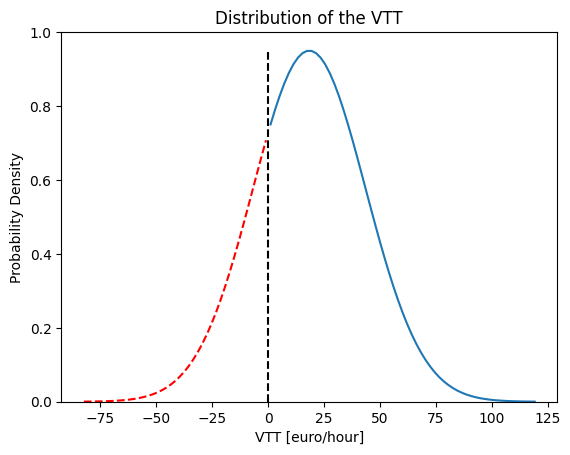

In [17]:
# Plot the estimated normal distribution

# Get the mean and standard deviation from the beta_hat table
mean_normal = beta_hat.loc['vtt']['Value']
std_dev_normal = beta_hat.loc['sigma_vtt']['Value']

# Create a vector of 100 points between +/- 4 standard deviations from the mean
x= np.linspace(mean_normal - 4*std_dev_normal, mean_normal + 4*std_dev_normal, 100)

# Plot the normal distribution in the positive domain. 
# Note that the x-axis is rescaled by 60 to convert from minutes to hours
# The scipy function "norm.pdf(x,mean, std_dev)" computes the probability density function of the normal distribution
plt.plot(x[x>0]*60, norm.pdf(x[x>0], mean_normal, std_dev_normal))

# Plot the normal distribution in the negative domain. 
plt.plot(x[x<0]*60, norm.pdf(x[x<0], mean_normal, std_dev_normal), color='red',linestyle='dashed')

# Add a vertical line to highlight the zero
plt.plot([0,0], [0,np.max(norm.pdf(x[x>0], mean_normal, std_dev_normal))], color='black',linestyle='dashed')

# Add labels and title
plt.xlabel('VTT [euro/hour]')
plt.ylabel('Probability Density')
plt.ylim([0,1])
plt.title(f'Distribution of the VTT')
plt.show()

### `4.4 Reflection`<br>
* Using a Mixed Logit model in the Willingness-to-Pay space, we are able to estimate the distribution of the VTT **directly** . Hence, this model allows jointly for unobserved heterogeneity in cost and time without running into problems caused by dividing by zero.  
* But, we see that a substantial part of the VTT distribution lies in the negative domain. This is behaviourally counterintuitive. In general, people prefer to arrive quicker at their destination rather than later. This is due to the assumption that the VTT is normally distributed. Perhaps this assumption needs revisiting...


## `Exercise 1: ML with log-normally distributed VTT`

Now, **you** will try the assumption that the VTT distribution in the population is **`log-normally distributed`** (as opposed to normally distributed).<br>

To do that, you must create a random vtt parameter with a log-normal VTT distribution. Draws from the log-normal distribution can be obtained from draws from the normal distribution as follows: <br>

            vtt_rnd = exp(mu + sigma  * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))
            

Estimate this model and interpret its results.<br>

`Questions:`

`A` Compare the log-likelihood of the ML model with normal distribution and with log-normal distribution. Which model fits better?<br>

`B` What can you conclude from the `vtt` and `sigma` parameters?<br>

`C` Compute the mean of the estimated log-normal distribution, i.e. `mean_lognormal` (based on your estimated `mu` and `sigma`). <br>

**Hint**, take a look at [https://en.wikipedia.org/wiki/Log-normal_distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) to see how this is done. Look for the formula for the mean in the right-hand side panel on the web page.

`D` Plot the shape of the log-normal distribution for the estimated mu and sigma. <br>

 **Hint**, you can use the  scipy function "lognorm". But lognorm is differently parameterised. That is, instead of using a location parameter `mu`, it requires a `scale` parameter. The scale is simply the exponent of the location parameter mu (i.e. scale = exp(mu)). <br>
    
Alternatively, you compute it directly from the formula yourself using the location `mu` and standard deviation $\sigma$:<br>
    ${\frac {1}{x\sigma {\sqrt {2\pi }}}}\ \exp \left(-{\frac {\left(\ln x-\mu \right)^{2}}{2\sigma ^{2}}}\right)$

In [18]:
# your code

#### `Answers`

In [19]:
# Give the model a name
model_name = 'ML WTP space with log-normally distributed VTT'

# Parameters definition enabling the construction of random parameters
mu   = Beta('mu',     -1, None, None, 0)
B_tc = Beta('b_tc', -1, None, None, 0)    
sigma  = Beta('sigma', 1, None, None, 0)

# Construction of random parameters   
vtt_rnd = exp(mu + sigma * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))

# Definition of the utility functions 
V_L = B_tc * (CostL + vtt_rnd * TimeL)
V_R = B_tc * (CostR + vtt_rnd * TimeR)   

# Create a dictionary to list the utility functions with the numbering of alternatives
V = {1: V_L, 2: V_R}
            
 # Create a dictionary to describe the availability conditions of each alternative
av = {1: 1, 2: 1} 

In [20]:
# The conditional probability of the chosen alternative is a logit
condProb = models.logit(V, av ,Chosen)

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condProb)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata , LL)


# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name

# Compute the null loglikelihood for reporting
biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.getEstimatedParameters()
print(beta_hat)

File biogeme.toml has been parsed. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            b_tc              mu           sigma     Function    Relgrad   Radius      Rho      
    0              -1              -1               1        6e+03       0.33        5    -0.92    - 
    1              -1              -1               1        6e+03       0.33      2.5      -77    - 
    2              -1              -1               1        6e+03       0.33      1.2 -1.2e+02    - 
    3              -1              -1               1        6e+03       0.33     0.62      -25    - 
    4              -1              -1               1        6e+03       0.33     0.31    -0.54    - 
    5           -0.69            -1.3               1      5.6e+03        0.1      3.1        1   ++ 
    6           -0.93            -1.4             1.1      5.6e+03      0.014       31      1.1   ++ 
    7   

Results for model ML WTP space with log-normally distributed VTT
Nbr of parameters:		3
Sample size:			10926
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-5569.516
Likelihood ratio test (null):		4007.621
Rho square (null):			0.265
Rho bar square (null):			0.264
Akaike Information Criterion:	11145.03
Bayesian Information Criterion:	11166.93

          Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc  -1.017226      0.238149    -4.271385      0.000019
mu    -1.463050      0.020912   -69.961364      0.000000
sigma  1.139934      0.042740    26.671554      0.000000


1. Compare the log-likelihood of the ML model with normal distribution and with log-normal distribution. Which model fits better?<br>

        --> The log-normal distribution fits better, as it has a higher log-likelihood (-5568.529 vs -5739.896)

2. What can you conclude from the $\mu$ and $\sigma$ parameters?<br>

        --> The parameters are significant, and negative. But furthermore hard to interpret

3. Compute the mean of the log-normal distribution (based on your estimated $\mu$ and $\sigma$). <br>

        --> The mean of the log-normal VTT distribution is €25.99 per hour

In [21]:
mu = beta_hat.loc['mu']['Value']
sigma = beta_hat.loc['sigma']['Value']
mean_lognormal = np.exp(mu + np.square(sigma)/2) * 60
print(f'The mean of the log-normal VTT distribution is: €{mean_lognormal:.2f} per hour')

The mean of the log-normal VTT distribution is: €26.60 per hour


4. Plot the shape of the log-normal distribution using the estimated mu and sigma

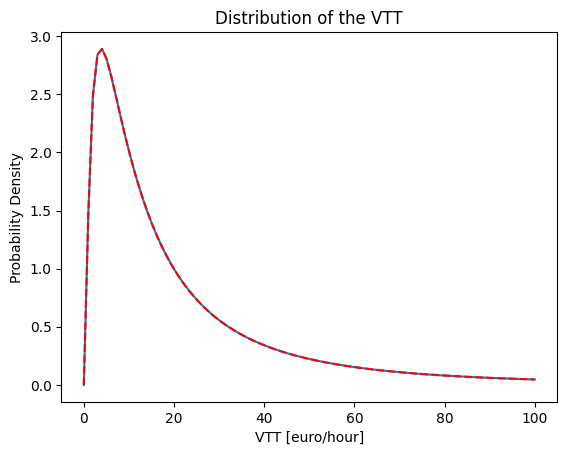

In [22]:
# Plot the estimated log-normal distribution
x = np.linspace(0.0001, 100/60, 100)

# Compute the pdf of the log-normal distribution, based on mu and sigma_sq
pdf_lognorm1 = (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-np.square(np.log(x)-mu)/(2*np.square(sigma)))
pdf_lognorm2 = lognorm.pdf(x, s = sigma, scale= np.exp(mu))

# Plot the log-normal distribution. Note that x is rescaled by 60 to convert from minutes to hours
plt.plot(x*60, pdf_lognorm1)
plt.plot(x*60, pdf_lognorm2, color='red',linestyle='dashed')

# Add labels and title
plt.xlabel('VTT [euro/hour]')
plt.ylabel('Probability Density')
# plt.ylim([0,3])
plt.title(f'Distribution of the VTT')
plt.show()

## `5. Panel Mixed Logit model`

Thus far, we have worked on the assumption that each choice observation is uncorrelated with all other choice observations. However, this data set contains multiple choices per respondent. In the ML modelling framework, we can also account for correlation in unobserved utility **across observations** of the same individual if we specify it as a panel ML model. In the panel ML model, the likelihood of the sequence of choices *t* = 1..*T* of an individual *n* is given by:  

$L_n(i_1,...,i_{T})(\beta_n|\sigma) = \int_{\beta_n}\Pi_{t=1}^T     P_{n}(i_t|\beta_n) f(\beta_n|\sigma)d\beta_n$

This likelihood does not have a closed-form expression. Therefore, as before, it needs to be approximated using simulation. Let's re-estimate the ML model assuming a normally distributed VTT distribution while accounting for panel structure. To do this, we first need to convert the data set into a so-called wide data format. In a wide format data set, each row contains all the choices belonging to an individual. Conveniently, Biogeme has a built-in function to do this (but, rather inconveniently, the names of the columns still need to be renamed).

### `5.1. Preparing a wide Biogeme database for estimating panel ML model`

In this cell we transform our data set into a wide format, and create a new Biogeme database object.

In [23]:
# Tell Biogeme which variable is the identifier of the individuals
biodata.panel('RespID')

# Calculate the number of observations per individual
obs_per_ind = biodata.data['RespID'].value_counts().unique()[0]
print(f'Number of observations per individual: {obs_per_ind}')

# Use biogeme's "generateFlatPanelDataFrame to create a wide database in which each row corresponds to one individual
df_wide = biodata.generateFlatPanelDataframe(identical_columns=None)

# Rename the columns, such that they run from columnname_{0} to columnname_{n} 
renumbered_columns = {col: f'{col.split("_")[1]}_{int(col.split("_")[0])-1}' if len(col.split("_")) == 2 else col for col in df_wide.columns}

# Rename the columns using the dictionary
df_wide.rename(columns=renumbered_columns, inplace=True)

# Create Biogeme database object
biodata_wide = db.Database('Norway2009VTT_wide', df_wide)
biodata_wide.data.head()

Number of observations per individual: 9


,Purpose,IncClass,Gender,AgeClass,Mode,Chosen_0,CostL_0,CostR_0,TimeL_0,TimeR_0,Chosen_1,CostL_1,CostR_1,TimeL_1,TimeR_1,Chosen_2,CostL_2,CostR_2,TimeL_2,TimeR_2,Chosen_3,CostL_3,CostR_3,TimeL_3,TimeR_3,Chosen_4,CostL_4,CostR_4,TimeL_4,TimeR_4,Chosen_5,CostL_5,CostR_5,TimeL_5,TimeR_5,Chosen_6,CostL_6,CostR_6,TimeL_6,TimeR_6,Chosen_7,CostL_7,CostR_7,TimeL_7,TimeR_7,Chosen_8,CostL_8,CostR_8,TimeL_8,TimeR_8
RespID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
289,5,6,1,3,1,1.0,31.444444,28.666667,76.0,95.0,2.0,25.333333,28.666667,95.0,78.0,1.0,28.666667,24.555556,95.0,117.0,1.0,28.666667,50.333333,108.0,95.0,1.0,23.111111,28.666667,95.0,68.0,1.0,28.666667,42.333333,95.0,74.0,1.0,14.333333,28.666667,81.0,67.0,1.0,22.444444,28.666667,108.0,95.0,1.0,28.666667,57.333333,123.0,95.0
432,5,6,2,4,1,2.0,38.111111,45.666667,200.0,180.0,1.0,49.000000,45.666667,180.0,198.0,1.0,45.666667,68.888889,214.0,180.0,2.0,25.111111,45.666667,231.0,180.0,2.0,22.888889,45.666667,153.0,102.0,1.0,51.000000,45.666667,149.0,180.0,2.0,22.888889,45.666667,180.0,136.0,2.0,22.888889,45.666667,180.0,142.0,2.0,91.333333,45.666667,131.0,180.0
590,5,8,1,3,1,2.0,29.222222,36.000000,122.0,105.0,1.0,18.000000,36.000000,122.0,105.0,1.0,38.555556,36.000000,105.0,120.0,1.0,36.000000,72.000000,105.0,80.0,1.0,18.000000,36.000000,105.0,81.0,1.0,18.000000,36.000000,105.0,74.0,2.0,36.000000,37.333333,105.0,90.0,1.0,38.555556,36.000000,121.0,136.0,1.0,43.111111,36.000000,105.0,133.0
731,5,3,2,3,1,2.0,100.000000,104.333333,299.0,270.0,1.0,121.666667,100.000000,204.0,270.0,1.0,116.000000,100.000000,270.0,314.0,2.0,100.000000,68.000000,185.0,230.0,2.0,100.000000,65.333333,225.0,270.0,1.0,50.000000,100.000000,331.0,270.0,1.0,100.000000,97.888889,270.0,345.0,1.0,50.555556,100.000000,270.0,201.0,1.0,100.000000,155.111111,270.0,231.0
761,5,7,1,5,1,1.0,23.000000,31.111111,110.0,85.0,2.0,23.000000,26.222222,129.0,110.0,1.0,16.888889,23.000000,110.0,94.0,2.0,23.000000,13.111111,110.0,122.0,1.0,11.555556,23.000000,110.0,88.0,1.0,23.000000,46.000000,141.0,110.0,1.0,26.888889,23.000000,78.0,110.0,1.0,23.000000,46.000000,145.0,126.0,2.0,23.000000,11.555556,110.0,128.0


### `5.2. Panel ML model with normally distributed VTT`

In [24]:
# Give the model a name
model_name = 'Panel ML WTP space with normally distributed vtt'

# Parameters definition enabling the construction of random parameters
vtt       = Beta('vtt',       0.4, None, None, 0)
B_tc      = Beta('b_tc',     -0.4, None, None, 0)    
sigma_vtt = Beta('sigma_vtt ',  2, None, None, 0)

# Construction of random parameters   
vtt_rnd = vtt + sigma_vtt * bioDraws('vtt_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions
# Note that we use list comprehension to create a list of utility functions for all observations of an individual 
V_L = [B_tc * (Variable(f'CostL_{q}') + vtt_rnd * Variable(f'TimeL_{q}')) for q in range(obs_per_ind)]
V_R = [B_tc * (Variable(f'CostR_{q}') + vtt_rnd * Variable(f'TimeR_{q}')) for q in range(obs_per_ind)]

# Create a dictionary to list the utility functions with the numbering of alternatives
# Note that we use list comprehension to create a list of dictionaries
V = [{1: V_L[q], 2: V_R[q]} for q in range(obs_per_ind)]
           
# Create a dictionary to describe the availability conditions of each alternative
av = {1:1, 2:1}

In [25]:
# The conditional probability of the chosen alternative is a logit
condProb = [models.loglogit(V[q], av, Variable(f'Chosen_{q}')) for q in range(obs_per_ind)] 

# Take the product of the conditional probabilities
condprobIndiv = exp(bioMultSum(condProb))   # exp to convert from logP to P again

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condprobIndiv)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata_wide , LL)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name
                                
# Compute the null loglikelihood for reporting
# Note that we need to compute it manually, as biogeme does not do this for panel data
biogeme.nullLogLike = len(biodata_wide.data)*np.log(1/2)*obs_per_ind

# Estimate the parameters and print the results
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.getEstimatedParameters()
print(beta_hat)

File biogeme.toml has been parsed. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            b_tc      sigma_vtt              vtt     Function    Relgrad   Radius      Rho      
    0            -0.4               2             0.4      7.2e+03       0.68        5  -9e+302    - 
    1            -0.4               2             0.4      7.2e+03       0.68      2.5 -3.3e+303    - 
    2            -0.4               2             0.4      7.2e+03       0.68      1.2 -1.1e+304    - 
    3            -0.4               2             0.4      7.2e+03       0.68     0.62     -7.2    - 
    4            -0.4               2             0.4      7.2e+03       0.68     0.31     -4.9    - 
    5          -0.088             1.7           0.088      6.1e+03       0.23     0.31     0.65    + 
    6           -0.12             1.4            0.11      5.9e+03       0.12      3.1        1   ++ 
    7 

Results for model Panel ML WTP space with normally distributed vtt
Nbr of parameters:		3
Sample size:			1214
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-5154.601
Likelihood ratio test (null):		4837.45
Rho square (null):			0.319
Rho bar square (null):			0.319
Akaike Information Criterion:	10315.2
Bayesian Information Criterion:	10330.51

               Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc       -0.188612      0.008732   -21.599474           0.0
sigma_vtt  -0.314775      0.014186   -22.188725           0.0
vtt         0.311869      0.009974    31.267721           0.0


In [26]:
# Compute the value of travel time
VTT_WTP_ML_PANEL_normal = 60 * beta_hat.loc['vtt']['Value']
print(f'Value of travel time Panel ML model in WTP space:  €{VTT_WTP_ML_PANEL_normal:.2f} per hour')

Value of travel time Panel ML model in WTP space:  €18.71 per hour


## `Exercise 2: Panel ML with log-normally distributed VTT`

Now, **you** will estimate a ML model under the assumption that the VTT is log-normally distributed, while accounting for panel effects.<br>

To do so, copy the code from the Panel ML model in WTP space with normally distributed VTT, and create the log-normally distributed random parameter (as you have done in exercise 1).<br>  
Estimate this model and interpret the results.<br>

`Questions:`

`A` Compare the log-likelihood of the ML models with the log-normally distributed VTTs, which do and do not account for the panel effect. Which model fits better?<br>

`B` Compute the mean of the VTT for the Panel ML model with the log-normally distributed VTT and compare it with the non-panel model. Has it changed?<br>

`C`  i. Print the recovered mean VTTs of the models we have estimated below each other.<br>
* MNL model<br>
* ML model with Normal distribution in utility space<br>
* ML model with Normal distribution in wtp space<br>
* ML model with Log-normal in wtp space<br>
* Panel ML with Normal distribution in wtp space<br>
* Panel ML with Log-normal distribution in wtp space<br>                     

ii. Compare the VTTs of the models with a normal distribution and a log-normal distribution. Do you see a pattern? <br>

iii. What could explain this pattern?<br> 

In [27]:
## Your code here

#### `Answers`

In [28]:
# Give the model a name
model_name = 'Panel ML WTP space with log-normally distributed vtt'

# Parameters definition enabling the construction of random parameters
mu          = Beta('mu',       0.4, None, None, 0)
B_tc        = Beta('b_tc',    -0.4, None, None, 0)    
sigma       = Beta('sigma',      2, None, None, 0)

# Construction of random parameters   
vtt_rnd = exp(mu + sigma * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))

# Definition of the utility functions 
V_L = [B_tc * (Variable(f'CostL_{q}') + vtt_rnd * Variable(f'TimeL_{q}')) for q in range(9)]
V_R = [B_tc * (Variable(f'CostR_{q}') + vtt_rnd * Variable(f'TimeR_{q}')) for q in range(9)]

# Create a dictionary to list the utility functions with the numbering of alternatives
V = [{1: V_L[q], 2: V_R[q]} for q in range(9)]
           
# Create a dictionary to describe the availability conditions of each alternative
av = {1:1, 2:1}

In [29]:
# The conditional probability of the chosen alternative is a logit
condProb = [models.loglogit(V[q], av, Variable(f'Chosen_{q}')) for q in range(9)] 

# Take the product of the conditional probabilities
condprobIndiv = exp(bioMultSum(condProb))   # exp to convert from logP to P again

# The unconditional probability is obtained by simulation
uncondProb = MonteCarlo(condprobIndiv)

# The Log-likelihood is the log of the unconditional probability
LL = log(uncondProb)

# Create the Biogeme estimation object containing the data and the model
biogeme = bio.BIOGEME(biodata_wide , LL)

# Set reporting levels
biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name
                                
# Compute the null loglikelihood for reporting
biogeme.nullLogLike = len(biodata_wide.data)*np.log(1/2)*9

# Estimate the parameters
results = biogeme.estimate()
print(results.short_summary())

# Get the results in a pandas table
beta_hat = results.getEstimatedParameters()
print(beta_hat)

File biogeme.toml has been parsed. 


Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            b_tc              mu           sigma     Function    Relgrad   Radius      Rho      
    0           -0.15            -8.6              -8        6e+03       0.47       10     0.12    + 
    1           -0.15            -8.6              -8        6e+03       0.47        5   0.0014    - 
    2           -0.15            -8.6              -8        6e+03       0.47      2.5  -0.0025    - 
    3           -0.15            -8.6              -8        6e+03       0.47      1.2    0.041    - 
    4           -0.15            -8.6              -8        6e+03       0.47     0.62    0.097    - 
    5          -0.094            -8.1            -7.4      5.9e+03       0.29     0.62     0.23    + 
    6           -0.11            -7.5            -7.5      5.9e+03      0.063      6.2      1.4   ++ 
    7           -0.11            -7.5       

Results for model Panel ML WTP space with log-normally distributed vtt
Nbr of parameters:		3
Sample size:			1214
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-5118.549
Likelihood ratio test (null):		4909.554
Rho square (null):			0.324
Rho bar square (null):			0.324
Akaike Information Criterion:	10243.1
Bayesian Information Criterion:	10258.4

          Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc  -0.197797      0.009283   -21.306517           0.0
mu    -1.377395      0.033395   -41.245238           0.0
sigma -0.833080      0.031623   -26.344189           0.0


In [30]:
mu = beta_hat.loc['mu']['Value']
sigma = beta_hat.loc['sigma']['Value'] 
mean_lognormal_panel = np.exp(mu + np.square(sigma)/2) * 60
print(f'The mean of the log-normal VTT distribution is: €{mean_lognormal_panel:.2f} per hour')

The mean of the log-normal VTT distribution is: €21.41 per hour


1. Compare the log-likelihood of the ML model in WTP space with the log-normal distribution taking into account random taste parameters and panel effects. Which model fits better?<br>

        --> The ML accounting panel effects fits better, as it has a higher log-likelihood (-5117.58 vs -5150.105)


2. Compute the mean of the log-normal dsitribution based on your estimated $\mu$ and $\sigma$ and compare it with the non-panel model. Has it changed?. <br>

        --> The mean of the log-normal VTT distribution for the panel model is: ~€21 per hour, while the mean of the log-normal VTT distribution for the non-panel model is above €25 per hour. Hence, the estimated VTT is considerably affected (lowered) by accounting for the panel structure of the data.

3. a. Print the recovered mean VTTs of the models that we have estimated below each other

In [31]:
print(f'1 MNL model:\t\t\t\t\t\t\t€{VTT_MNL:.2f} per hour')
print(f'2 ML model with Normal distribution - util space: \t\t€{VTT_ML:.2f} per hour')
print(f'3 ML model with Normal distribution - wtp space: \t\t€{VTT_WTP_ML:.2f} per hour')
print(f'4 ML model with Log-normal - wtp space: \t\t\t€{mean_lognormal:.2f} per hour')
print(f'5 Panel ML with Normal distribution - wtp space: \t\t€{VTT_WTP_ML_PANEL_normal:.2f} per hour')
print(f'6 Panel ML with Log-normal distribution - wtp space: \t\t€{mean_lognormal_panel:.2f} per hour')

1 MNL model:							€18.96 per hour
2 ML model with Normal distribution - util space: 		€18.39 per hour
3 ML model with Normal distribution - wtp space: 		€18.45 per hour
4 ML model with Log-normal - wtp space: 			€26.60 per hour
5 Panel ML with Normal distribution - wtp space: 		€18.71 per hour
6 Panel ML with Log-normal distribution - wtp space: 		€21.41 per hour


3. b. Compare the VTTs of the models with a normal distribution and a log-normal distribution. Do you see a pattern? <br>

        --> The models with the assumption that the VTT is log-normally distributed tend to yield a higher estimate of the mean VTT.

   c. What could explain this pattern?

        --> This is caused by the fat tail of the log-normal distribution. It shifts the mean to the right (higher). 

### `5.4. Impact of the number of draws on modelling outcomes`

## `Exercise 3: Impact of the number of draws` 

For all the Mixed Logit models that we have estimated, we have used 50 draws (see the beginning of this notebook). We choose a relatively low number of draws to avoid long estimation times.  <br>

Next, we analyse how sensitive the modelling outcomes are towards the number of draws. To do this, we have estimated a Panel Mixed Logit model using different numbers of draws, ranging from 33 to 2,000, and stored the results. <br>

The following plots show the results. 

![Draws](data/draws_vs_.png)

`Questions:`

`A` The left-hand side plot shows that the VTT estimate gets more stable with an increasing number of draws. Can you explain why the estimate gets more stable? 

`B` What number of draws do you deem sufficient for estimating this model? Explain your answer.

`C` The right-hand side plot shows a linear relation between the number of draws and the estimation time. Explain why a linear relation was to be expected.

`D` Suppose we estimate a model with *K* random parameters. Would the relation between the number of draws and estimation time still be linear? Explain your answer. 

<br>

#### `Answers`

1. ... Can you explain why the estimate gets more stable?<br>

        --> The approximation of the integral gets more and more accurate with increasing number of draws. This stabilises the estimates.
2. What number of draws is sufficient? Explain your answer

        --> Above 500 draws, the results are stable. But the variance keeps reducing with more draws.

3. ... Explain why a linear relation was to be expected.

        --> The number of computations is one-to-one related to the number of draws. And, the number of draws does not systematically seem to affect the number of iterations the optimiser needs to converge. Therefore, we see a linear relationship between the number of draws and estimation time.

4. ... Would the relation between the number of draws and estimation time still be linear? 

        --> The estimation time will linearly scale with the number of random parameters, as the number of computations is one-to-one related to the number of random parameters. 


## END

In [ ]:
# Below is the code to create the plot 

# Create a dataframe to store the results
df_out = pd.DataFrame(columns=['num_draws','VTT', 'LL','elapsed_time'])

# Define the number of draws to be used for Monte-Carlo simulation
num_draws = list(range(33, 201, 33))

# Loop over the number of draws
for R in num_draws:
    
    # Start the timer
    start_time = time.time()

    # Give the model a name
    model_name = f'Panel ML WTP space with log-normally distributed vtt with {R} draws'

    # Change the number of draws in the .toml file
    with open('biogeme.toml', 'r') as file:
        data = toml.load(file)

    # Modify the value
    data['MonteCarlo']['number_of_draws'] = R

    # Write the modified data back to the .toml file
    with open('biogeme.toml', 'w') as file:
        toml.dump(data, file)

    # Parameters definition enabling the construction of random parameters
    vtt         = Beta('vtt',       0.4, None, None, 0)
    B_tc        = Beta('b_tc',     -0.4, None, None, 0)    
    sigma_vtt   = Beta('sigma_vtt',   2, None, None, 0)

    # Construction of random parameters   
    vtt_rnd = exp(vtt + sigma_vtt * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))

    # Definition of the utility functions 
    V_L = [B_tc * (Variable(f'CostL_{q}') + vtt_rnd * Variable(f'TimeL_{q}')) for q in range(9)]
    V_R = [B_tc * (Variable(f'CostR_{q}') + vtt_rnd * Variable(f'TimeR_{q}')) for q in range(9)]

    # Create a dictionary to list the utility functions with the numbering of alternatives
    V = [{1: V_L[q], 2: V_R[q]} for q in range(9)]
            
    # Create a dictionary to describe the availability conditions of each alternative
    av = {1:1, 2:1}

    # The conditional probability of the chosen alternative is a logit
    condProb = [models.loglogit(V[q], av, Variable(f'Chosen_{q}')) for q in range(9)] 

    # Take the product of the conditional probabilities
    condprobIndiv = exp(bioMultSum(condProb))   # exp to convert from logP to P again

    # The unconditional probability is obtained by simulation
    uncondProb = MonteCarlo(condprobIndiv)

    # The Log-likelihood is the log of the unconditional probability
    LL = log(uncondProb)

    # Create the Biogeme estimation object containing the data and the model
    biogeme = bio.BIOGEME(biodata_wide , LL)
    
    # Set reporting levels
    biogeme.generate_pickle = False
    biogeme.generate_html = False
    biogeme.saveIterations = False
    biogeme.modelName = model_name
                                    
    # Compute the null loglikelihood for reporting
    biogeme.nullLogLike = len(biodata_wide.data)*np.log(1/2)*9

    # Estimate the parameters
    results = biogeme.estimate()
    # print(results.short_summary())

    # Get the results in a pandas table
    beta_hat = results.getEstimatedParameters()
    # print(beta_hat)

    # End the timer
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Elapsed time: {elapsed_time:.2f} seconds\n\n')

    # Compute the mean value of travel time
    mu = beta_hat.loc['vtt']['Value']
    sigma = beta_hat.loc['sigma_vtt']['Value'] 
    mean_lognormal_panel = np.exp(mu + np.square(sigma)/2) * 60
    
    # Add the results to the dataframe
    df_R = pd.DataFrame({'num_draws': [R], 'VTT': [mean_lognormal_panel], 'LL': [results.getGeneralStatistics()['Final log likelihood'][0]], 'elapsed_time': [elapsed_time]})
    df_out = pd.concat([df_out, df_R])

# Show the results
df_out

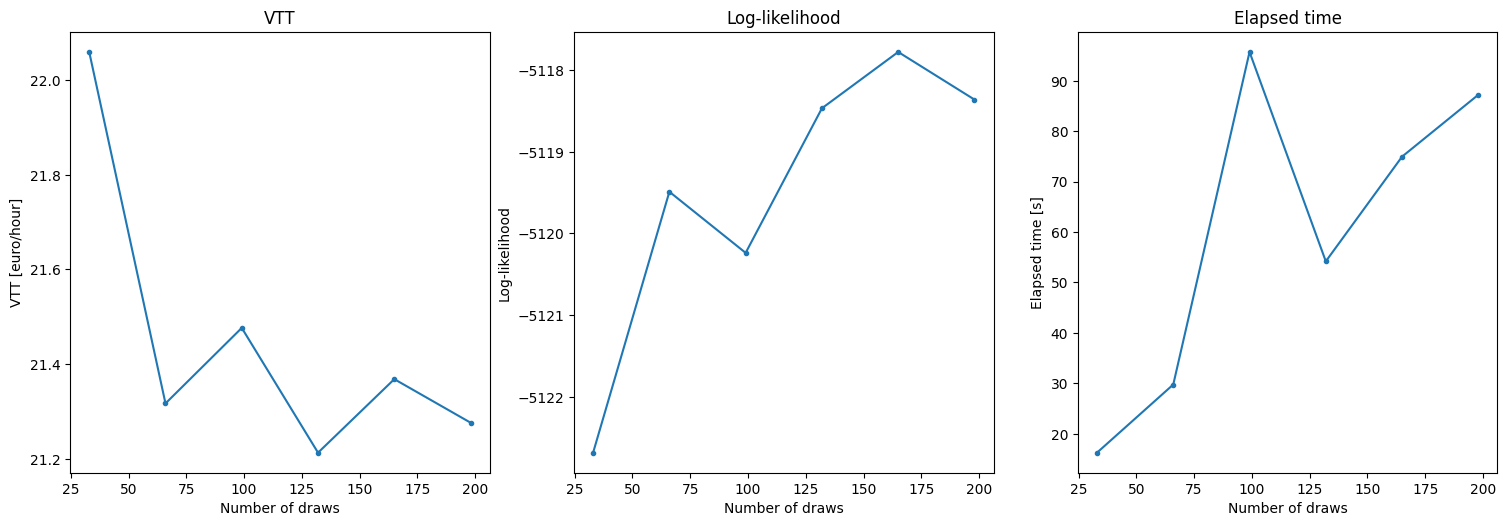

In [ ]:
# Plot the results in a figure
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True)
fig.tight_layout(w_pad=3)

ax[0].plot(df_out['num_draws'], df_out['VTT'], marker='.')
ax[0].set_xlabel('Number of draws')
ax[0].set_ylabel('VTT [euro/hour]')
ax[0].set_title('VTT')

ax[1].plot(df_out['num_draws'], df_out['LL'], marker='.')
ax[1].set_xlabel('Number of draws')
ax[1].set_ylabel('Log-likelihood')
ax[1].set_title('Log-likelihood')

ax[2].plot(df_out['num_draws'], df_out['elapsed_time'], marker='.')
ax[2].set_xlabel('Number of draws')
ax[2].set_ylabel('Elapsed time [s]')
ax[2].set_title('Elapsed time')

plt.show()